In [348]:
import json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from math import log
import matplotlib as mpl
from matplotlib.ticker import MaxNLocator, FormatStrFormatter
import itertools

from utils import *

mpl.rcParams['figure.dpi'] = 400

# show more dataframe rows
pd.set_option('display.min_rows', 50)
pd.set_option('display.max_rows', 100)

import matplotlib.style
mpl.style.use('ggplot')

scheme_to_color = {
    'DoubleDecyclingMinimizer': "orange",
    'Miniception': "red",
    'Mod-minimizer': "blue",
    'Random minimizer': "grey"
}

In [258]:
def read(file):
    with open(file, 'r') as f:
        data = json.load(f)
    df = pd.json_normalize(data)

    # Rename column 'tp.minimizer_type' to 'Minimizer type'
    df = df.rename(columns={'tp.minimizer_type': 'Minimizer type'})
    # In type column replace minizer value with random minimizer.
    df['Minimizer type'] = df['Minimizer type'].replace('Minimizer', 'Random minimizer')
    df['Minimizer type'] = df['Minimizer type'].replace('LrMinimizer', 'LR-minimizer')
    df['Minimizer type'] = df['Minimizer type'].replace('ModMinimizer', 'Mod-minimizer')
    df['Minimizer type'] = df['Minimizer type'].replace('MiniceptionNew', 'Modified miniception')

    df['param'] = df['tp.k0'].fillna(0) #+ df['tp.r'].fillna(0)

    return df

In [594]:
all_sigmas = [2, 4, 256]
# all_sigmas = [4]
df_by_sigma = []
for sigma in all_sigmas:
    datafile = f"/home/Users/blk6/Contribute/minimizers/data/practical_{sigma}.json"
    df_by_sigma.append(read(datafile))

df_random = pd.concat(df_by_sigma).sort_values("k")
df_random["text"] = "Random"

datafile = f"/home/Users/blk6/Contribute/minimizers/data/practical_chm13Y.json"
df_chm13 = read(datafile)
df_chm13["text"] = "ChrY"

df = pd.concat([df_random, df_chm13]).sort_values("k")
all_window_sizes = sorted(df["w"].unique())
all_scheme_names = sorted(df["Minimizer type"].unique())
pprint(sorted(all_scheme_names))

['AltRotMinimizer',
 'BdAnchor',
 'DecyclingMinimizer',
 'DoubleDecyclingMinimizer',
 'LR-minimizer',
 'Miniception',
 'Mod-minimizer',
 'ModSampling',
 'Modified miniception',
 'OpenClosedSyncmerMinimizer',
 'OpenSyncmerMinimizer',
 'Random minimizer',
 'RotMinimizer']


In [595]:
scheme_names = [
    # 'AltRotMinimizer',
    # 'BdAnchor',
    # 'DecyclingMinimizer',
    'DoubleDecyclingMinimizer',
    # 'LR-minimizer',
    'Miniception',
    'Mod-minimizer',
    # 'ModSampling',
    # 'Modified miniception',
    # 'OpenClosedSyncmerMinimizer',
    # 'OpenSyncmerMinimizer',
    'Random minimizer',
    # 'RotMinimizer'
]
# scheme_names = all_scheme_names
df_schemes = df[df["Minimizer type"].isin(scheme_names)].sort_values("k")

## Gap table

In [573]:
sigma = 4
w = 5
k = 31
text = "Random"
for w, k in [(5, 31), (10, 15), (19, 19)]:
    df_comp = df_schemes[
    (df_schemes["w"] == w) 
    & (df_schemes["sigma"] == sigma) 
    & (df_schemes["k"] == k)
    & (df_schemes["text"] == text)]
    best = df_comp.loc[df_comp["density"].idxmin()]
    best_density = best["density"]
    best_scheme = best["Minimizer type"]
    lower_bound = aperiodic_bound_suff(w, k, sigma)
    
    print(f"For w={w}, k={k}, {best_scheme} performed best w/ a density of {best_density:.4f}.")
    print(f"Gap decreased from {100*(best_density-(1/w))/(1/w):.2f}% --> {100*(best_density-lower_bound)/lower_bound:.2f}%")
    print()

For w=5, k=31, Mod-minimizer performed best w/ a density of 0.2258.
Gap decreased from 12.91% --> 1.61%

For w=10, k=15, Mod-minimizer performed best w/ a density of 0.1434.
Gap decreased from 43.38% --> 11.12%

For w=19, k=19, DoubleDecyclingMinimizer performed best w/ a density of 0.0790.
Gap decreased from 50.08% --> 2.69%



## $\sigma=4$ plot

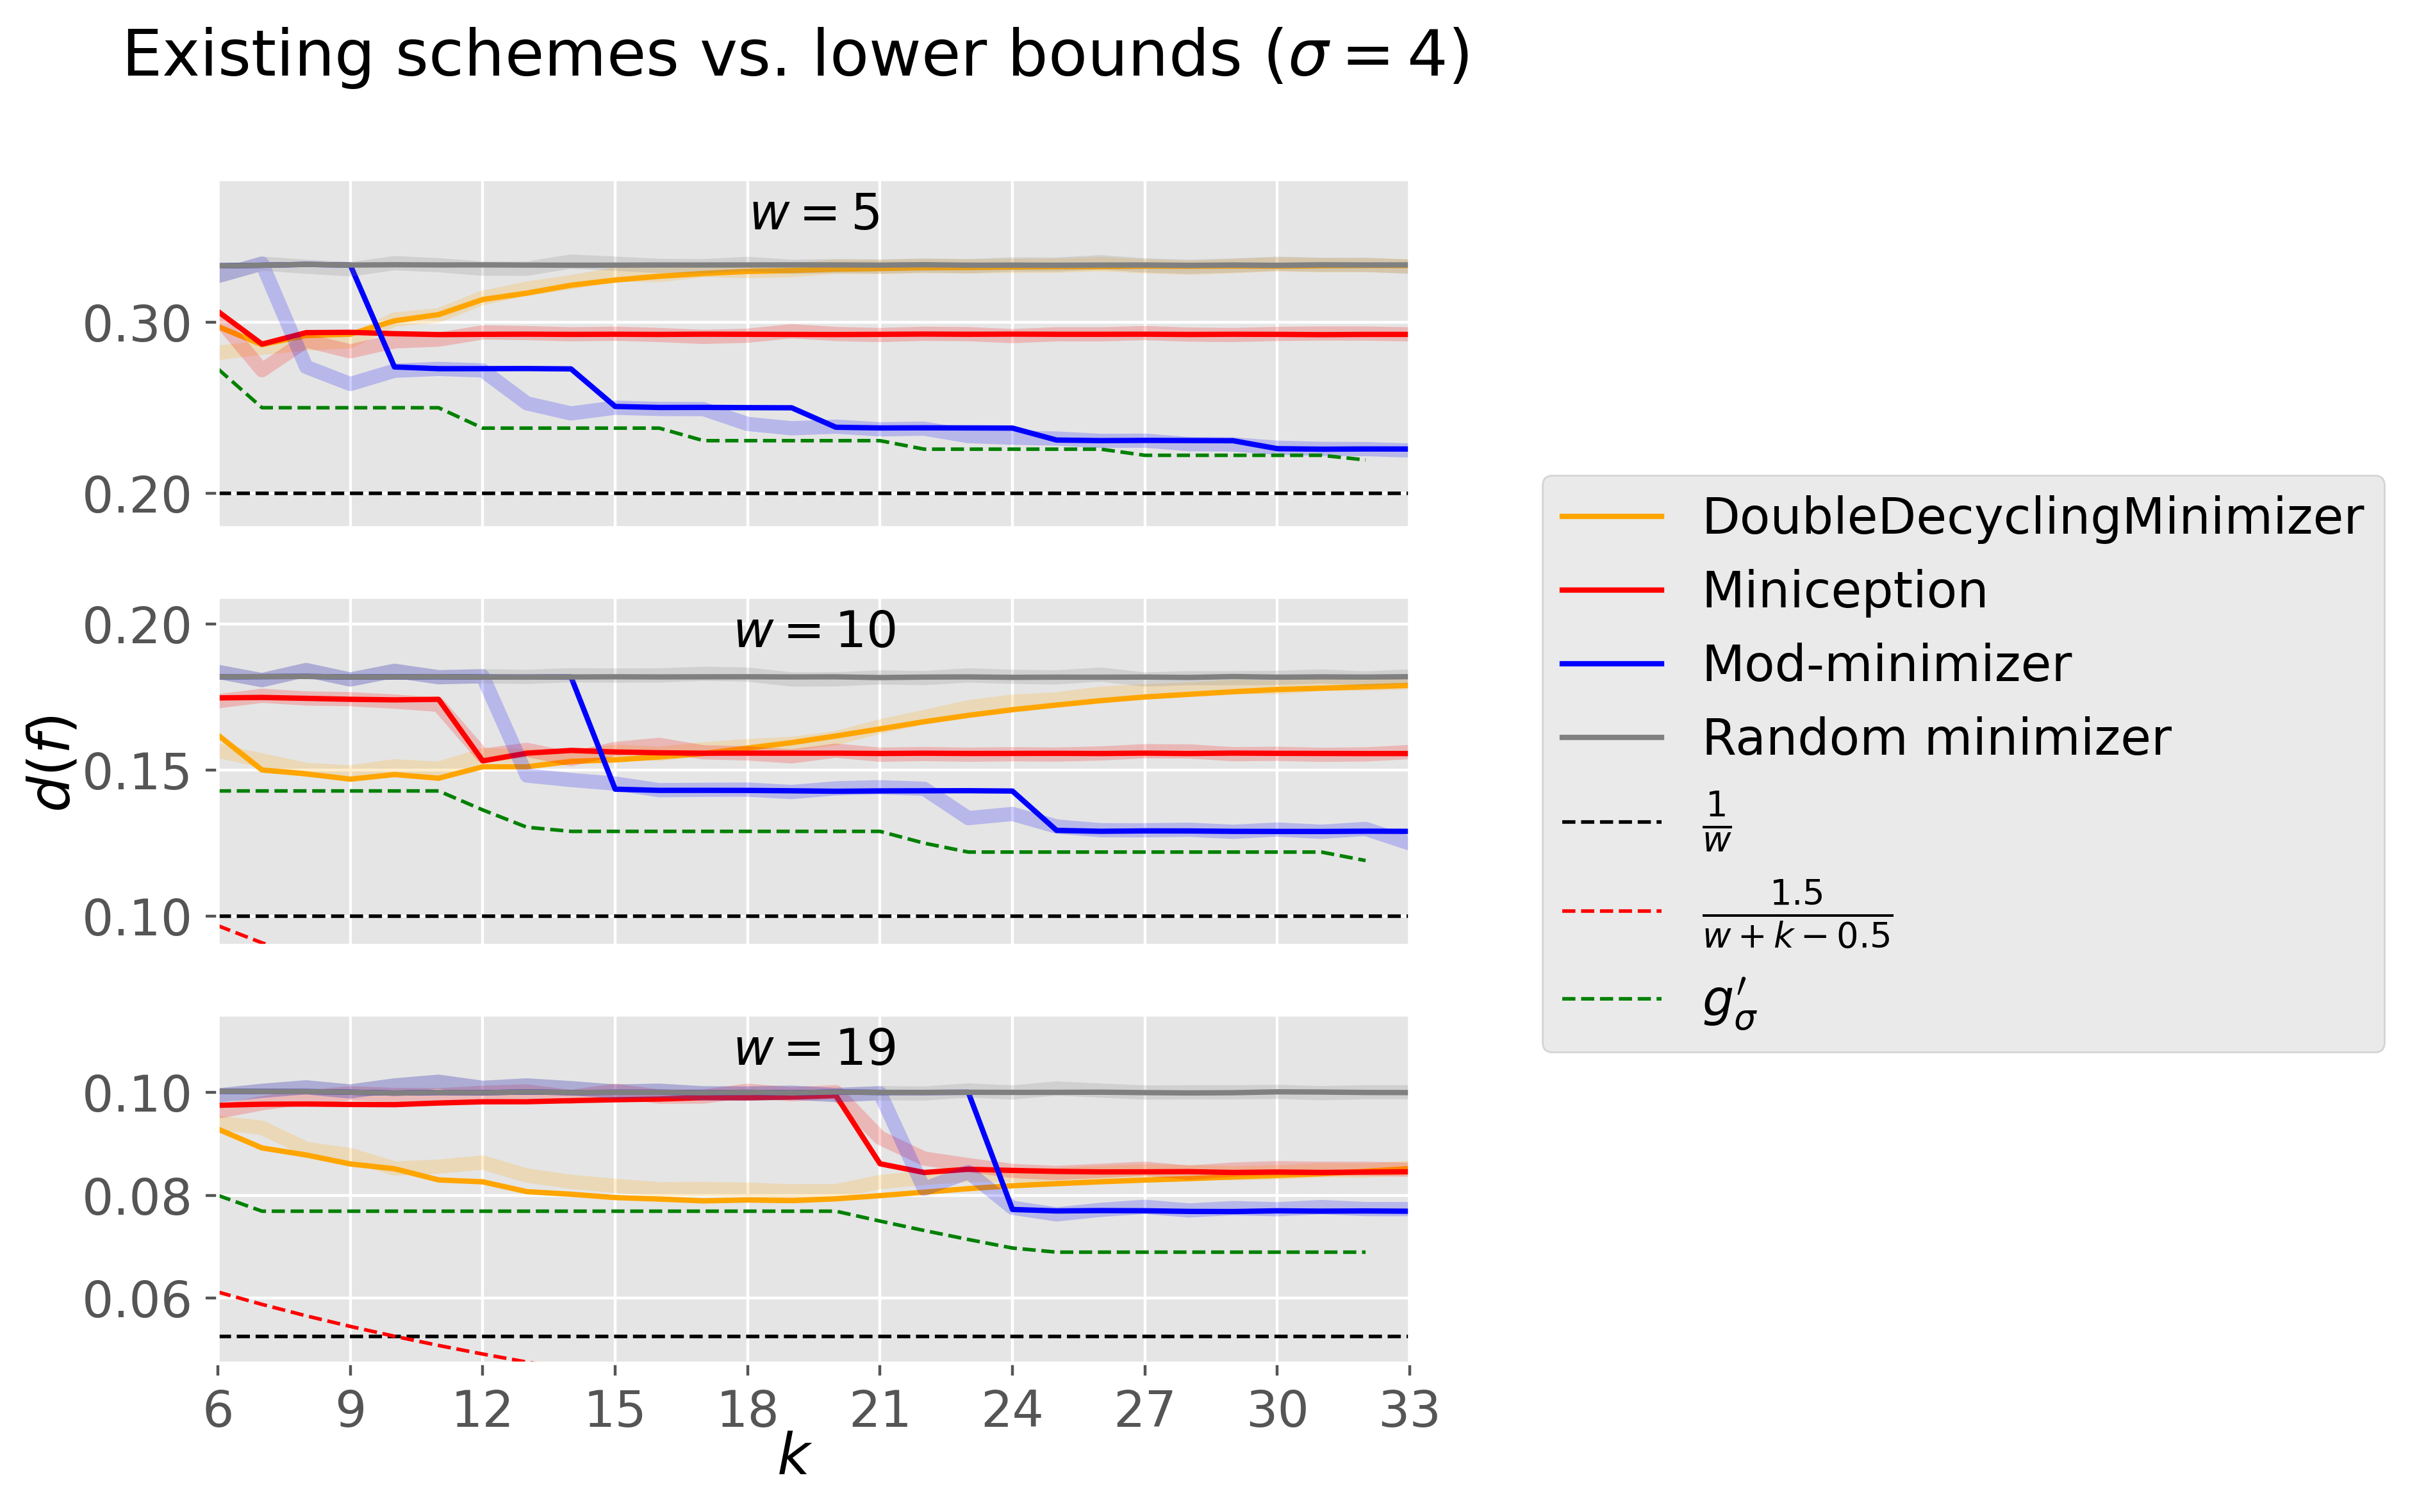

In [604]:
w_range = [5, 10, 19]
k_min, k_max = 6, 33
plot_ratio = False
sigma = 4

title_font = 18
subplot_font = 14
plot_font = 16
legend_font = 14
fig_dpi = 300

fig, axs = plt.subplots(nrows=len(w_range), ncols=1)
fig.set_figheight(6)
fig.set_figwidth(6)

for idx, w in enumerate(w_range):
    df_sub = df_schemes[(df_schemes["w"] == w) & (df_schemes["sigma"] == sigma)]
    ax = axs[idx]
    
    for scheme in scheme_names:
        for text in ["Random", "ChrY"]:
            df_this = df_sub[(df_sub["Minimizer type"] == scheme) & (df_sub["text"] == text)]
            if plot_ratio:
                ratio = df_this.apply(lambda row: 100*((row["density"] - (1/w)) / (1/w)), axis=1)
                y_vals = ratio
            else:
                y_vals = df_this["density"]
                
            if text == "Random":
                ax.plot(df_this["k"], y_vals, label=scheme, color=scheme_to_color[scheme] if scheme in scheme_to_color else None)
            else:
                ax.plot(df_this["k"], y_vals, color=scheme_to_color[scheme], linewidth=4, alpha=.2)

    if not plot_ratio:
        # Plot lower bounds
        ax.axhline(1/w, color="black", linestyle="--", linewidth=1, label="$\\frac{1}{w}$")
        k_range = list(range(k_min, k_max))
        g_prime = [aperiodic_bound_suff(w, k, sigma) for k in k_range] 
        ax.plot(k_range, [ragnar_WABI_LB(w, k) for k in k_range], label="$\\frac{1.5}{w+k-0.5}$", color="red", linestyle="dashed", linewidth=1)
        ax.plot(k_range, g_prime, label=f"$g_\sigma^\prime$", color="green", linestyle="--", linewidth=1)

        # Pad upper and lower limits
        ax.set_ylim((.9/w, 2.3 / (w+1)))
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    else:
        ax.set_yscale("log")
    ax.set_xlim((k_min, k_max))
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    # Add label slightly below top
    ax.set_title(f"$w={w}$", y=1.0, pad=-14)
    
    prop={'size': subplot_font}    
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_font(prop)  
   

    # Turn off x-axis items for all axes except last
    if w != w_range[-1]:
        ax.tick_params( axis='x',          # changes apply to the x-axis
                        which='both',      # both major and minor ticks are affected
                        bottom=False,      # ticks along the bottom edge are off
                        top=False,         # ticks along the top edge are off
                        labelbottom=False) # labels along the bottom edge are off

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.55, .5), prop={'size': legend_font}, ncols=1)
fig.supxlabel("$k$", y=.03, fontsize=plot_font)
if plot_ratio:
    fig.suptitle(f"Gap between $g_{{{sigma}}}$ and existing schemes", fontsize=title_font)
    fig.supylabel(f"Gap ratio (%)", x=0, fontsize=plot_font)
else:
    fig.suptitle(f"Existing schemes vs. lower bounds ($\sigma={{{sigma}}}$)", fontsize=title_font)
    fig.supylabel(f"$d(f)$", x=0, fontsize=plot_font)

fig.savefig(f"media/benchmark-sigma{sigma}-{'ratio' if plot_ratio else 'density'}.png", dpi=fig_dpi, bbox_inches='tight')
fig.show()

## Grid plot

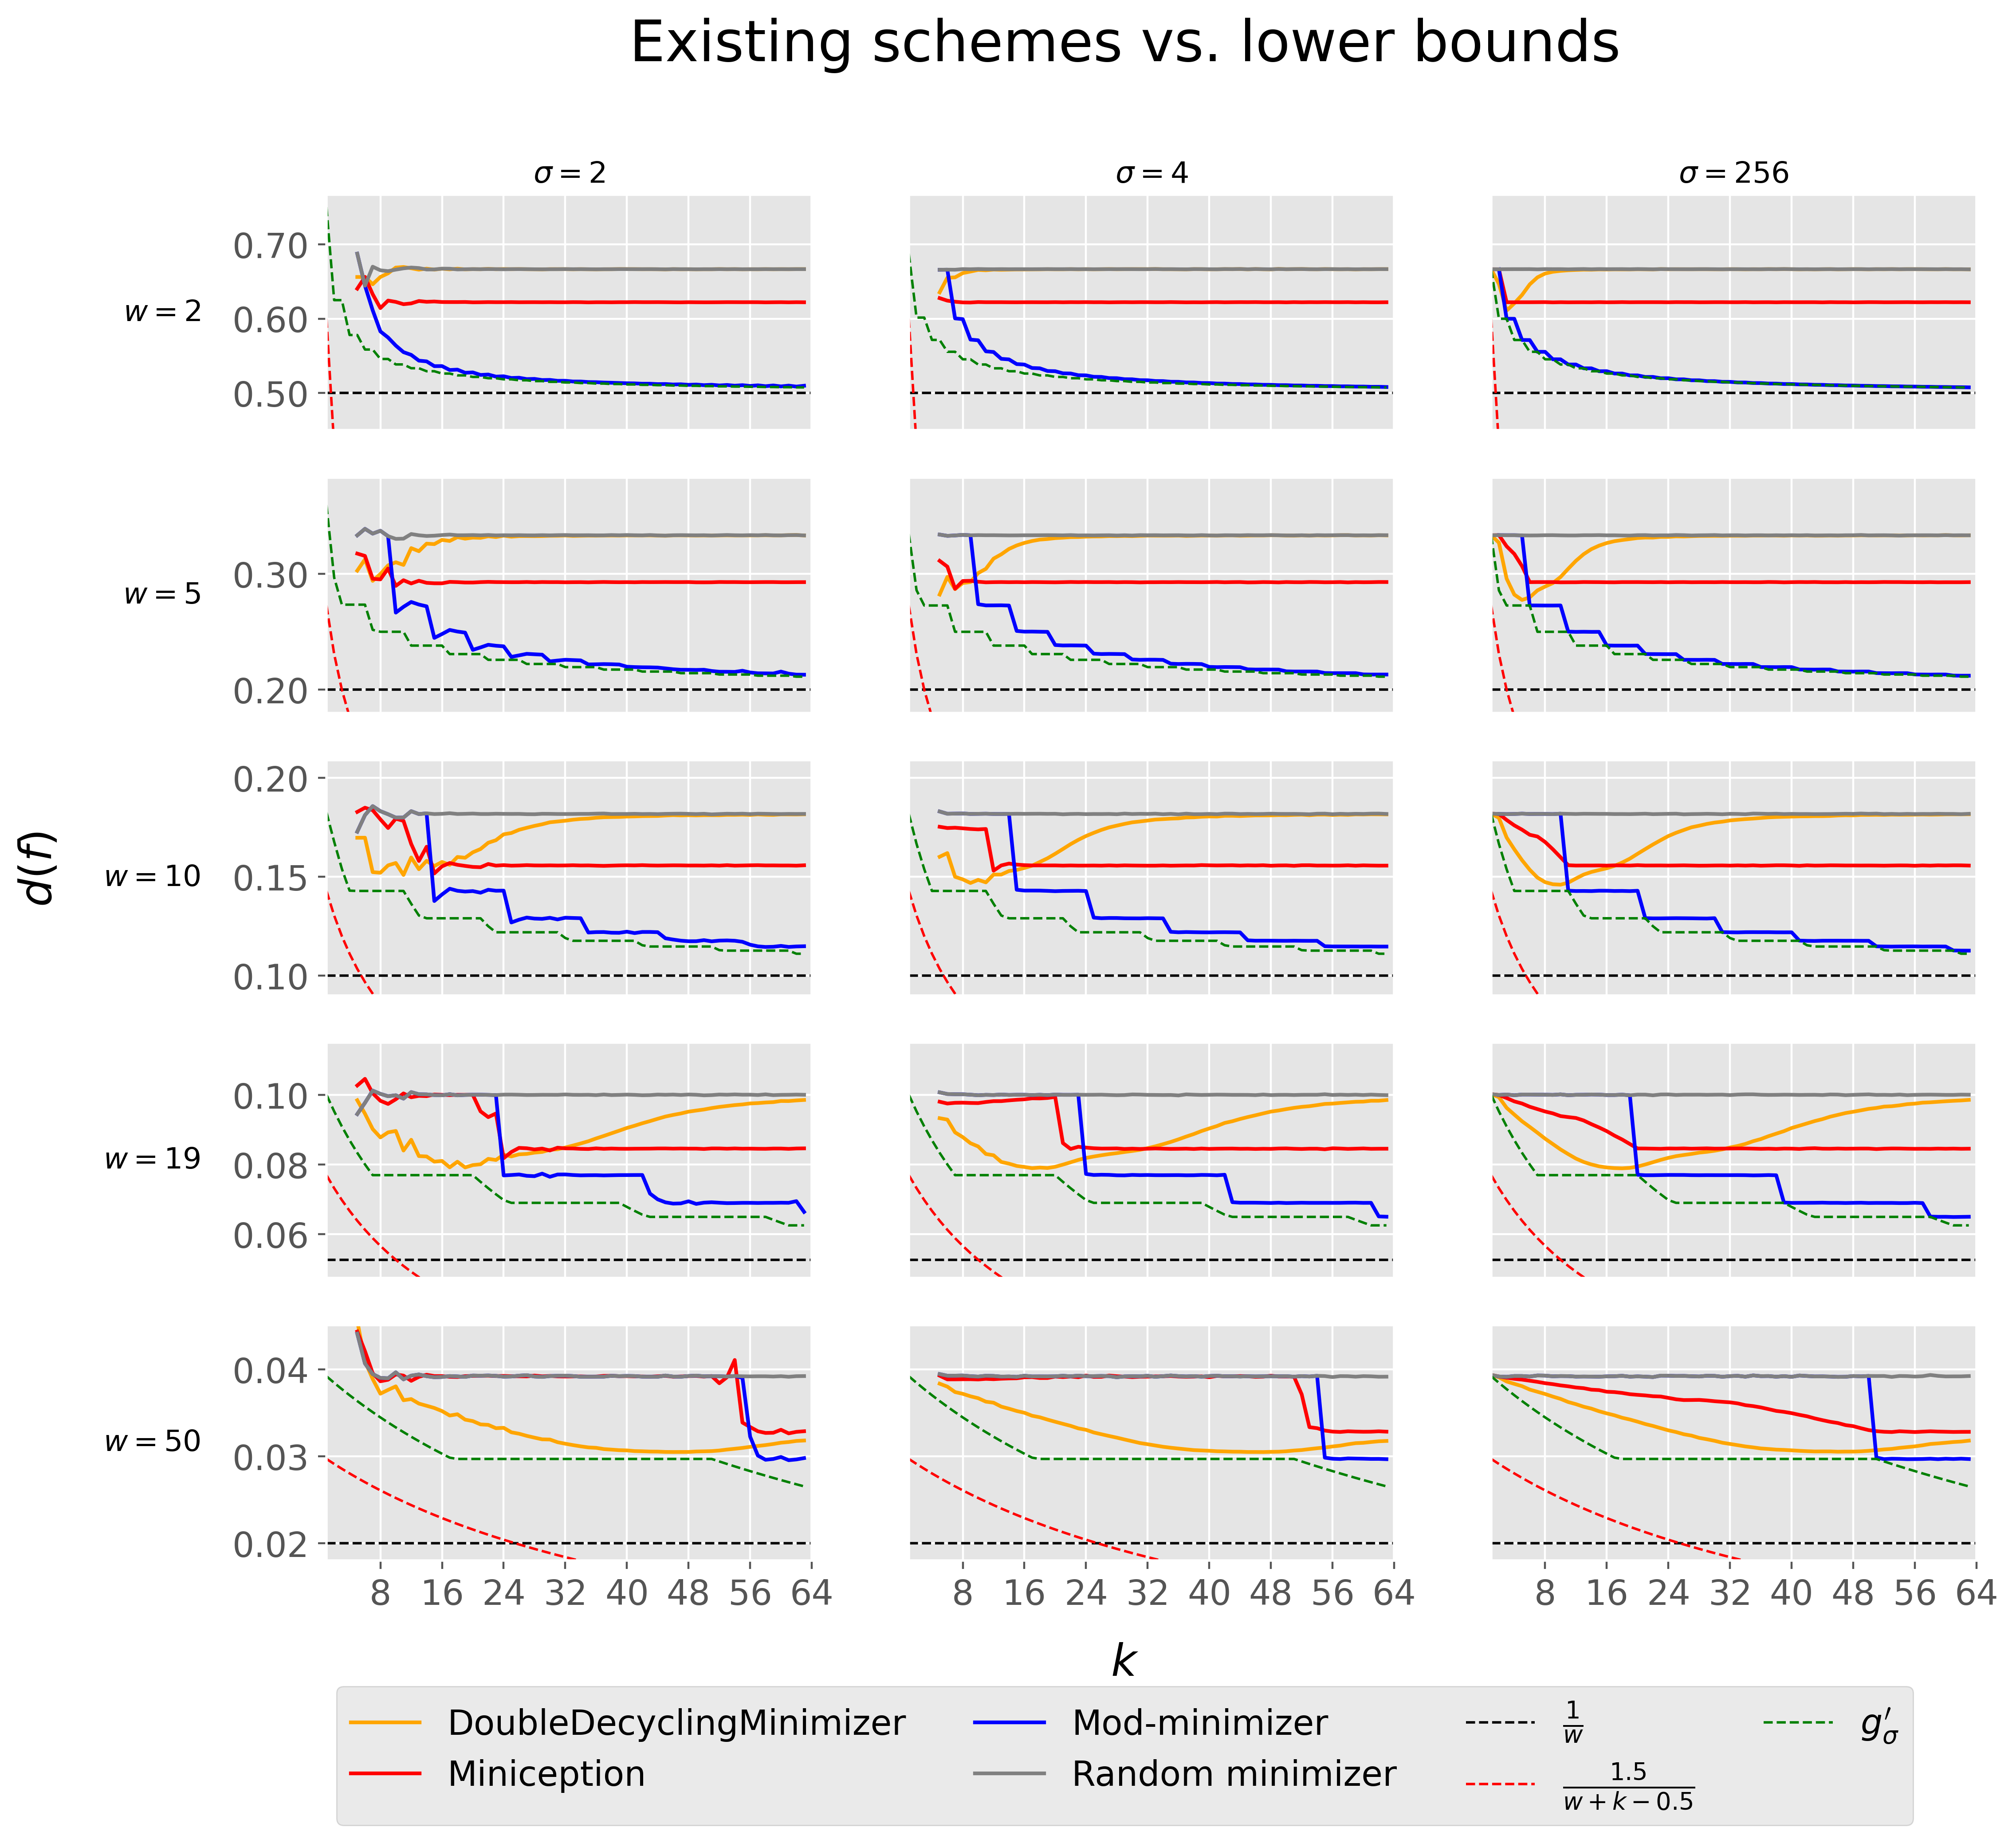

In [605]:
w_range = all_window_sizes
sigma_range = all_sigmas
k_min, k_max = 1, 64
plot_ratio = False

title_font = 23
subplot_font = 14
plot_font = 18
legend_font = 14
fig_dpi = 300

fig, axs = plt.subplots(nrows=len(w_range), ncols=len(all_sigmas))
fig.set_figheight(10)
fig.set_figwidth(12)
text = "Random"

for idx_sigma, sigma in enumerate(sigma_range):
    for idx_w, w in enumerate(w_range):
        df_sub = df_schemes[
            (df_schemes["w"] == w) 
            & (df_schemes["sigma"] == sigma)
            & (df_schemes["text"] == text)
        ]
        ax = axs[idx_w, idx_sigma]
        
        for scheme in scheme_names:
            df_this = df_sub[(df_sub["Minimizer type"] == scheme) & (df_sub["text"] == text)]
            if plot_ratio:
                ratio = df_this.apply(lambda row: 100*((row["density"] - (1/w)) / (1/w)), axis=1)
                y_vals = ratio
            else:
                y_vals = df_this["density"]
                
            if text == "Random":
                ax.plot(df_this["k"], y_vals, label=scheme, color=scheme_to_color[scheme] if scheme in scheme_to_color else None)
            else:
                ax.plot(df_this["k"], y_vals, color=scheme_to_color[scheme], linewidth=4, alpha=.2)
    
        if not plot_ratio:
            # Plot lower bounds
            ax.axhline(1/w, color="black", linestyle="--", linewidth=1, label="$\\frac{1}{w}$")
            k_range = list(range(k_min, k_max))
            g_prime = [aperiodic_bound_suff(w, k, sigma) for k in k_range] 
            ax.plot(k_range, [ragnar_WABI_LB(w, k) for k in k_range], label="$\\frac{1.5}{w+k-0.5}$", color="red", linestyle="dashed", linewidth=1)
            ax.plot(k_range, g_prime, label=f"$g_\sigma^\prime$", color="green", linestyle="--", linewidth=1)
    
            # Pad upper and lower limits
            ax.set_ylim((.9/w, 2.3 / (w+1)))
            ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        else:
            ax.set_yscale("log")
        ax.set_xlim((k_min, k_max))
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        
        prop={'size': subplot_font}    
        for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
            item.set_font(prop)  
       
        # Turn off x-axis items for all axes except last
        if w != w_range[-1]:
            ax.tick_params( axis='x',          
                            which='both',      
                            bottom=False,      
                            top=False,         
                            labelbottom=False) 

        # Turn off y-axis items for all axes except left
        if sigma != sigma_range[0] and not plot_ratio:
            ax.tick_params( axis='y',          
                            which='both',      
                            bottom=False,     
                            left=False,        
                            labelleft=False) 

# Add labels to rows and columns
axis_pad = 5
for ax, w in zip(axs[:,0], w_range):
    ax.annotate(f"$w={w}$", xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - axis_pad, 0),
        xycoords=ax.yaxis.label, textcoords='offset points',
        size='large', ha='right', va='center')
    
for ax, sigma in zip(axs[0], all_sigmas):
    ax.annotate(f"$\sigma={sigma}$", xy=(0.5, 1), xytext=(0, axis_pad),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')


handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(0.5, 0), loc='center', prop={'size': legend_font}, ncols=4)
fig.supxlabel("$k$", y=.04, fontsize=plot_font)
if plot_ratio:
    fig.suptitle(f"Gap between $g_{{{sigma}}}$ and existing schemes", fontsize=title_font)
    fig.supylabel(f"gap ratio", x=0, fontsize=plot_font)
else:
    fig.suptitle(f"Existing schemes vs. lower bounds", fontsize=title_font)
    fig.supylabel(f"$d(f)$", x=-0.02, fontsize=plot_font)

fig.savefig(f"media/benchmark-grid-{'ratio' if plot_ratio else 'density'}.png", dpi=fig_dpi, bbox_inches='tight')
fig.show()